# 3. Dueling Deep Q-Learning for Navigation

In 
this notebook I will give a third solution to the [Unity ML Banana-Collector environment](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#banana-collector) using [Doube Deep Q-Learning](https://arxiv.org/pdf/1509.06461.pdf). See the [README](https://github.com/bobflagg/Deep-Q-Learning-for-Navigation/blob/master/README.md) for instructions on how to setup your environment to run the code here.  


<img src="doc/images/dueling-dqn.png" alt="Deep Q-Network" style="margin-left: 140px;; margin-right: 100px;" />


The architecture of the Q-network in dueling deep Q-learning has two streams, one, with paraameters $\theta, \alpha$, estimates the state-value function:
$$V(s) = \mathbb{E}\big[Q(s,A_t)\big]$$
and the other, with paraameters $\theta, \beta$,  estimates the expression 
$$A(s,a) - \frac{1}{{\cal |A|}}\sum_{a'}A(s, a'),$$
where 
$$A(s,a) = Q(s,a) - V(s).$$
is the **advantage function**, which provides a relative measure of the importance of each action for a given state.

The estimate of the action-value function is then
$$Q(s,a|\theta, \alpha, \beta) = V(s|\theta, \beta) - \big(A(s,a|\theta, \alpha) - \frac{1}{{\cal |A|}}\sum_{a'}A(s, a'|\theta, \alpha)\big).$$

As in the figure above illustrates and the implementation below demonstrates, the two streams in a **DuelingQNetwork** share some weights, $\theta$, but have separate heads with independent parameters, $\alpha$ and $\beta$.  I don't use convolution in the network for the Unity ML-Agent Banana Collector so the shared $\theta$ parameters in this example are for a couple of simple fully connected linear layers.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DuelingQNetwork(nn.Module):
    
    def __init__(
        self, 
        state_size, 
        action_size, 
        seed=0, 
        fc1_units=64, 
        fc2_units=64,
        adv_fc_units=64, 
        val_fc_units=64, 
    ):

        super(DuelingQNetwork, self).__init__()
        
        self.state_size = state_size
        self.action_size = action_size
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)

        self.adv_fc1 = nn.Linear(fc2_units, adv_fc_units)
        self.adv_fc2 = nn.Linear(adv_fc_units, action_size)

        #self.adv_fc1 = nn.Linear(fc2_units, action_size)


        self.val_fc1 = nn.Linear(fc2_units, val_fc_units)
        self.val_fc2 = nn.Linear(val_fc_units, 1)
        #self.val_fc1 = nn.Linear(fc2_units, 1)
        
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        
        adv = F.relu(self.adv_fc1(x))
        adv = self.adv_fc2(adv)

        val = F.relu(self.val_fc1(x))
        val = self.val_fc2(val)

        return val + adv - adv.mean()


The changes requred to the DQN agent are minor: I just need to use dueling Q-networds for the local and target networks.

In [2]:
from dqn_agent import Agent, BUFFER_SIZE, BATCH_SIZE, LR, ReplayBuffer
import random
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DuelingAgent(Agent):
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0



## Dueling Deep Q-Learning

In [3]:
from trainer import train
from unityagents import UnityEnvironment

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.18
Episode 200	Average Score: 2.62
Episode 300	Average Score: 6.69
Episode 400	Average Score: 9.74
Episode 500	Average Score: 12.28
Episode 517	Average Score: 13.01
Environment solved in 417 episodes!	Average Score: 13.01


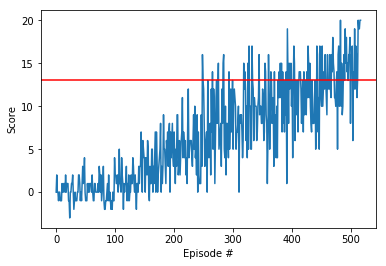

CPU times: user 4min 11s, sys: 23.2 s, total: 4min 35s
Wall time: 8min 30s


In [4]:
%%time
import matplotlib.pyplot as plt
%matplotlib inline  


env = UnityEnvironment(file_name="./data/Banana.app")
agent = DuelingAgent(state_size=37, action_size=4, seed=0)
scores = train(env, agent)

So the [Unity ML Banana-Collector environment](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#banana-collector)
was solved in 417 episodes. 

I'll save the weights of the local network of this successful agent to the file dueling-dqn-model-weights.pth.

In [5]:
torch.save(agent.qnetwork_local.state_dict(), 'dueling-dqn-model-weights.pth')